## Packages & Spark Session

In [1]:
#!pip install pyspark

In [2]:
# Import the necessary pyspark modules and spark context
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import *
from pyspark import SparkContext
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.clustering import KMeans

myconf = SparkConf()
myconf.setMaster('local')
myconf.setAppName('week2_exercise')
sc = SparkContext(conf=myconf)

sqlContext=SQLContext(sc)
spark=SparkSession.builder.master ("local[*]").appName("part3").getOrCreate()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Read Data

In [3]:
df = spark.read.option("header","True").option("inferSchema","True").option("sep",";").csv("/content/XYZ_Bank_Deposit_Data_Classification.csv")

## Data Wrangling

In [4]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



Column types look good

Now we need to remove periods from column names

In [5]:
def remove_periods_from_columns(df):
    """
    Remove periods from column names in a PySpark DataFrame.

    Parameters:
    - df: PySpark DataFrame

    Returns:
    - df: PySpark DataFrame with columns renamed
    """
    # Get the current column names
    columns = df.columns

    # Create a dictionary to store the mapping of old column names to new column names
    column_mapping = {col: col.replace('.', '_') for col in columns}

    # Use withColumnRenamed to rename each column
    for old_col, new_col in column_mapping.items():
        df = df.withColumnRenamed(old_col, new_col)

    return df

In [6]:
df = remove_periods_from_columns(df)

Changed column names that had periods to having underscores

## EDA - Nulls

In [7]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



No Nulls in data

## EDA - Numerical

View Correlations between Predictors

In [8]:
data=df.toPandas()
corr = data.dropna().corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-8-8b3e1f22dbc8>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.dropna().corr()
<ipython-input-8-8b3e1f22dbc8>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
age,1.00,-0.00,0.00,-0.03,0.02,-0.00,0.00,0.13,0.01,-0.02
duration,-0.00,1.00,-0.07,-0.05,0.02,-0.03,0.01,-0.01,-0.03,-0.04
campaign,0.00,-0.07,1.00,0.05,-0.08,0.15,0.13,-0.01,0.14,0.14
pdays,-0.03,-0.05,0.05,1.00,-0.59,0.27,0.08,-0.09,0.30,0.37
previous,0.02,0.02,-0.08,-0.59,1.00,-0.42,-0.20,-0.05,-0.45,-0.50
emp_var_rate,-0.00,-0.03,0.15,0.27,-0.42,1.00,0.78,0.20,0.97,0.91
cons_price_idx,0.00,0.01,0.13,0.08,-0.20,0.78,1.00,0.06,0.69,0.52
cons_conf_idx,0.13,-0.01,-0.01,-0.09,-0.05,0.20,0.06,1.00,0.28,0.10
euribor3m,0.01,-0.03,0.14,0.30,-0.45,0.97,0.69,0.28,1.00,0.95
nr_employed,-0.02,-0.04,0.14,0.37,-0.50,0.91,0.52,0.10,0.95,1.00


Some variables are highly correlated, we have multicollinearity.

Especially these:


1.   euribor3m
2.   nr_employed
3.   emp_var_rate




View Univariate Distributions

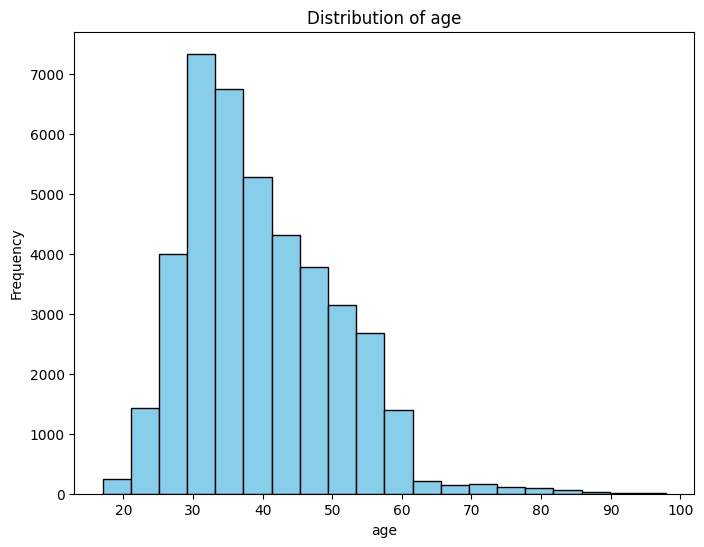

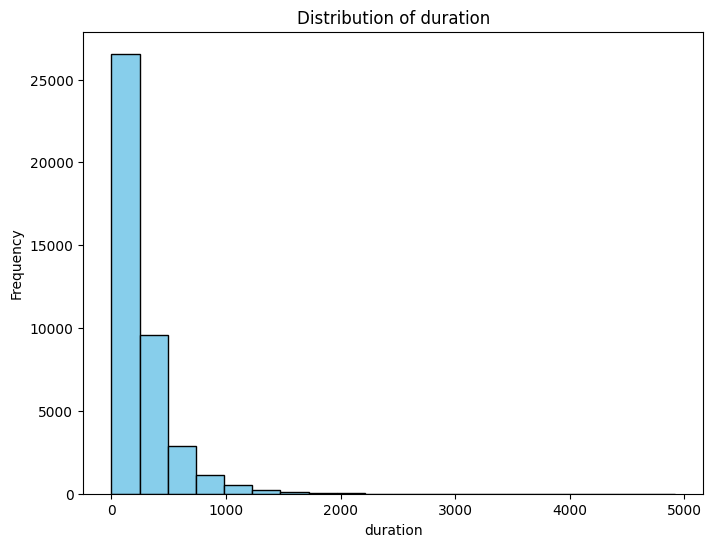

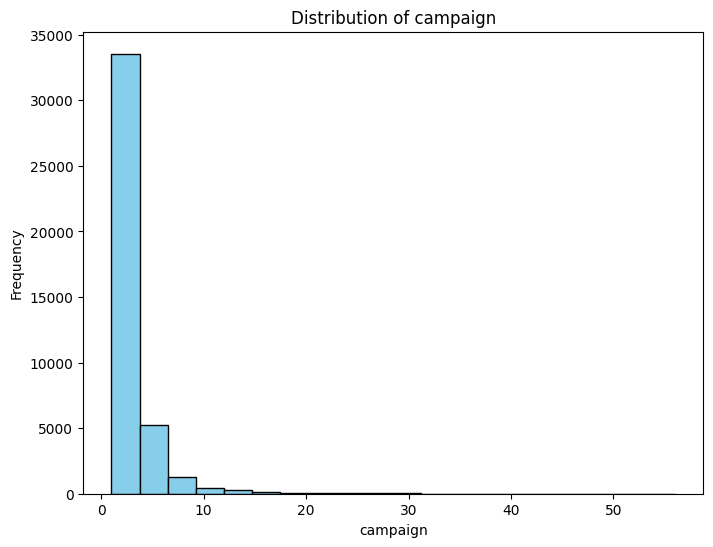

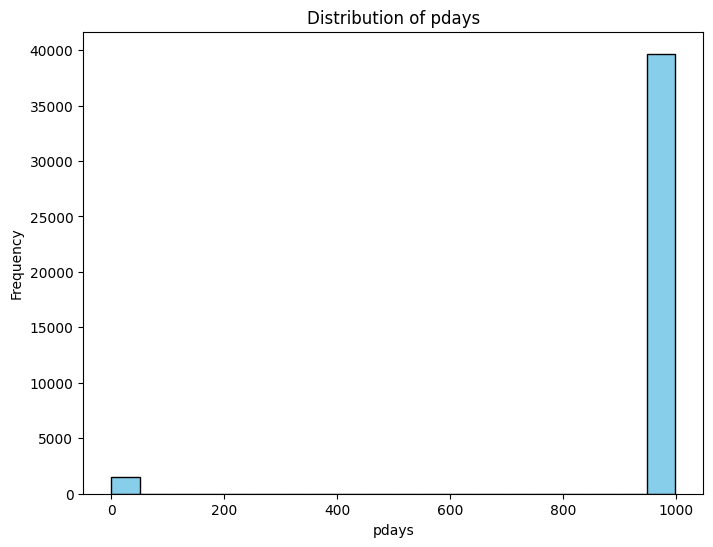

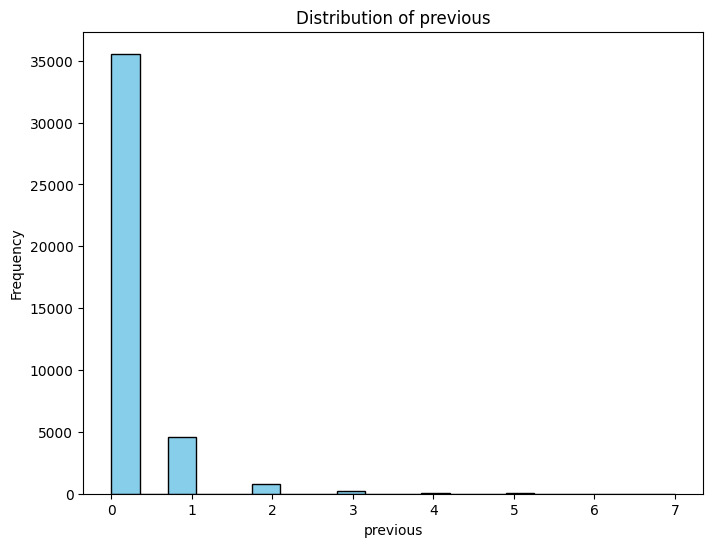

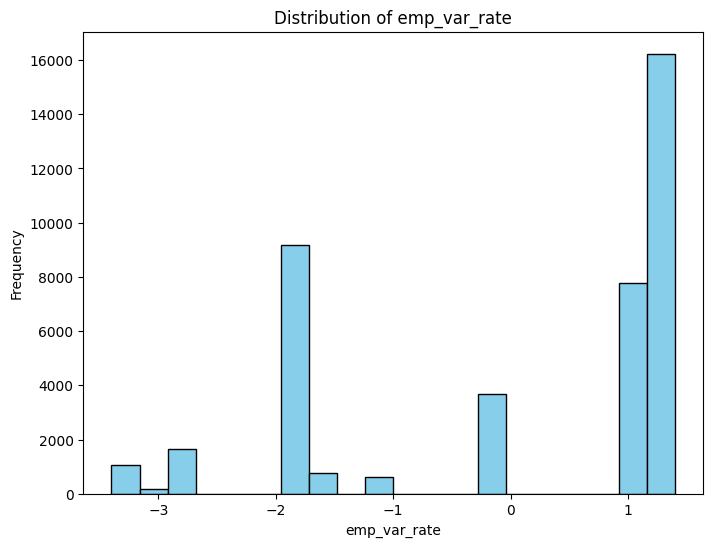

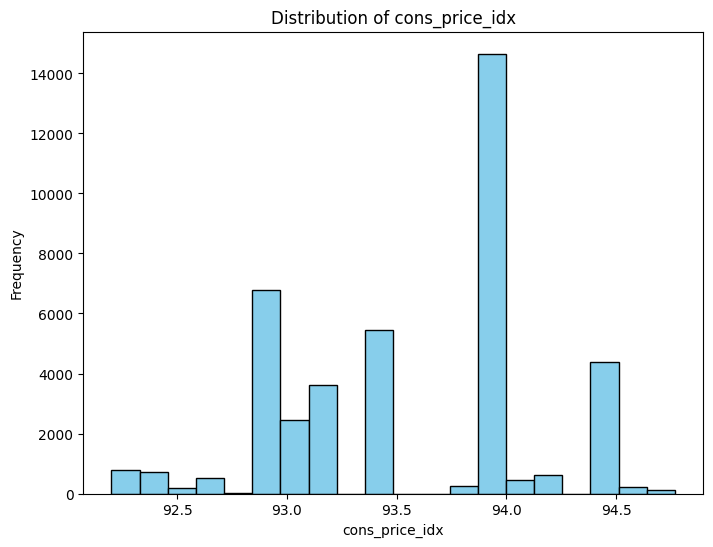

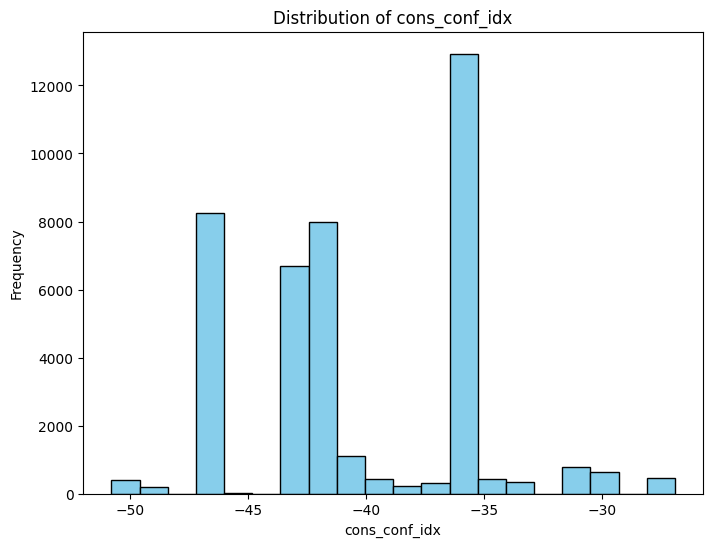

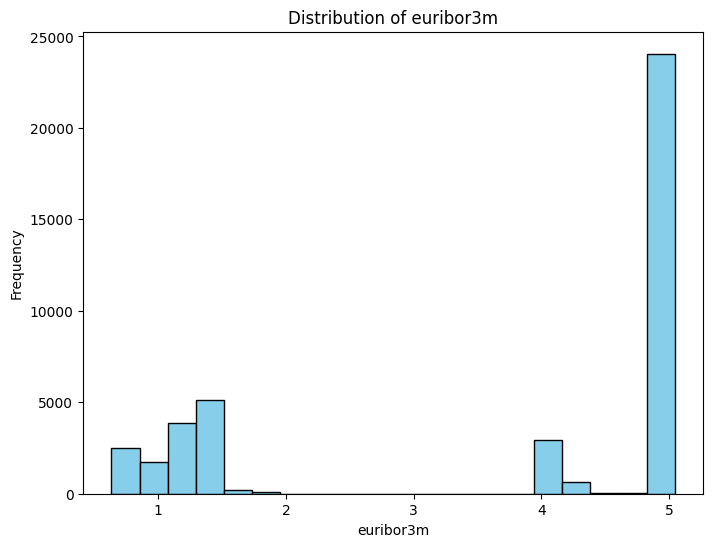

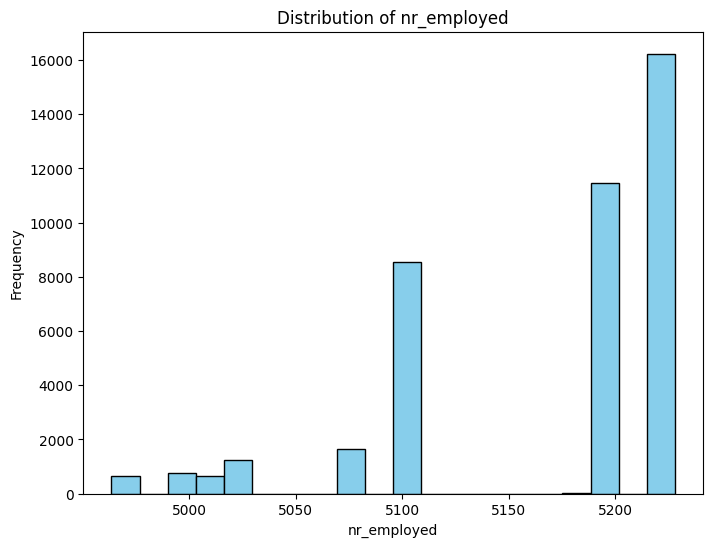

In [9]:
numerical_columns = [col[0] for col in df.dtypes if col[1] in ('int', 'double')]

# Plot histograms for all numerical variables
for column in numerical_columns:
    column_data = df.select(column).toPandas()

    plt.figure(figsize=(8, 6))
    plt.hist(column_data[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

None of the variables are normally distributed.

The closest ones will be transformed with StandardScaler: **age, duration, campaign, emp_var_rate, cons_price_idx, cons_conf_idx, nr_employed**

The others that look like they fall into two groups will be bucketed: **pdays** and **euribor3m** and **previous**

## Bucket Certain Numerical Variables

### Bucket *pdays*

In [10]:
# Define conditions for creating the new column
conditions = [
    (col("pdays") <= 200, "0"),
    (col("pdays") > 200, "1")
]

# Apply conditions using the 'when' function and create the new column 'pdaysGroup'
df = df.withColumn("pdaysGroup",
                  when(conditions[0][0], conditions[0][1])
                  .when(conditions[1][0], conditions[1][1])
                  .otherwise("0"))

Verify if grouping provided good separation in the target variable

In [11]:
count_y_by_pdaysGroup = df.groupBy('pdaysGroup').agg(
    F.sum(F.when(df['y'] == 'yes', 1).otherwise(0)).alias('count_y_yes'),
    F.sum(F.when(df['y'] == 'no', 1).otherwise(0)).alias('count_y_no')
)

count_y_by_pdaysGroup2 = count_y_by_pdaysGroup.withColumn('ratio', count_y_by_pdaysGroup['count_y_yes'] / (count_y_by_pdaysGroup['count_y_yes'] + count_y_by_pdaysGroup['count_y_no']))
count_y_by_pdaysGroup2 = count_y_by_pdaysGroup2.withColumn('yes_rate', F.round(count_y_by_pdaysGroup2['ratio'], 2))

count_y_by_pdaysGroup2.select('pdaysGroup','count_y_yes','count_y_no','yes_rate').show()

+----------+-----------+----------+--------+
|pdaysGroup|count_y_yes|count_y_no|yes_rate|
+----------+-----------+----------+--------+
|         0|        967|       548|    0.64|
|         1|       3673|     36000|    0.09|
+----------+-----------+----------+--------+



Good difference in the yes rate between the two groups, so we will keep this grouping

In [12]:
# Drop original column
df = df.drop('pdays')

### Bucket *euribor3m*

In [13]:
# Define conditions for creating the new column
conditions = [
    (col("euribor3m") <= 3, "0"),
    (col("euribor3m") > 3, "1")
]

# Apply conditions using the 'when' function and create the new column 'euribor3mGroup'
df = df.withColumn("euribor3mGroup",
                  when(conditions[0][0], conditions[0][1])
                  .when(conditions[1][0], conditions[1][1])
                  .otherwise("0"))

Verify if grouping provided good separation in the target variable

In [14]:
count_y_by_euribor3mGroup = df.groupBy('euribor3mGroup').agg(
    F.sum(F.when(df['y'] == 'yes', 1).otherwise(0)).alias('count_y_yes'),
    F.sum(F.when(df['y'] == 'no', 1).otherwise(0)).alias('count_y_no')
)

count_y_by_euribor3mGroup2 = count_y_by_euribor3mGroup.withColumn('ratio', count_y_by_euribor3mGroup['count_y_yes'] / (count_y_by_euribor3mGroup['count_y_yes'] + count_y_by_euribor3mGroup['count_y_no']))
count_y_by_euribor3mGroup2 = count_y_by_euribor3mGroup2.withColumn('yes_rate', F.round(count_y_by_euribor3mGroup2['ratio'], 2))

count_y_by_euribor3mGroup2.select('euribor3mGroup','count_y_yes','count_y_no','yes_rate').show()

+--------------+-----------+----------+--------+
|euribor3mGroup|count_y_yes|count_y_no|yes_rate|
+--------------+-----------+----------+--------+
|             0|       3301|     10197|    0.24|
|             1|       1339|     26351|    0.05|
+--------------+-----------+----------+--------+



Good difference in the yes rate between the two groups, so we will keep this grouping

In [15]:
# Drop original column
df = df.drop('euribor3m')

### Bucket *previous*

In [16]:
# Define conditions for creating the new column
conditions = [
    (col("previous") <= 0, "0"),
    (col("previous") > 0, "1")
]

# Apply conditions using the 'when' function and create the new column 'previousGroup'
df = df.withColumn("previousGroup",
                  when(conditions[0][0], conditions[0][1])
                  .when(conditions[1][0], conditions[1][1])
                  .otherwise("0"))

Verify if grouping provided good separation in the target variable

In [17]:
count_y_by_previousGroup = df.groupBy('previousGroup').agg(
    F.sum(F.when(df['y'] == 'yes', 1).otherwise(0)).alias('count_y_yes'),
    F.sum(F.when(df['y'] == 'no', 1).otherwise(0)).alias('count_y_no')
)

count_y_by_previousGroup2 = count_y_by_previousGroup.withColumn('ratio', count_y_by_previousGroup['count_y_yes'] / (count_y_by_previousGroup['count_y_yes'] + count_y_by_previousGroup['count_y_no']))
count_y_by_previousGroup2 = count_y_by_previousGroup2.withColumn('yes_rate', F.round(count_y_by_previousGroup2['ratio'], 2))

count_y_by_previousGroup2.select('previousGroup','count_y_yes','count_y_no','yes_rate').show()

+-------------+-----------+----------+--------+
|previousGroup|count_y_yes|count_y_no|yes_rate|
+-------------+-----------+----------+--------+
|            0|       3141|     32422|    0.09|
|            1|       1499|      4126|    0.27|
+-------------+-----------+----------+--------+



Good difference in the yes rate between the two groups, so we will keep this grouping

In [18]:
# Drop original column
df = df.drop('previous')

Now that the numerical columns have been prepared, let's look at the categorical columns

## EDA - Categorical

Check out groups & counts for each categorical variable

In [19]:
# Check out counts of categorical variables
df.groupBy("job").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("marital").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("education").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("default").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("housing").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("loan").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("contact").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("month").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("day_of_week").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("poutcome").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("y").count().orderBy("count", ascending=False).show(truncate=False)

+-------------+-----+
|job          |count|
+-------------+-----+
|admin.       |10422|
|blue-collar  |9254 |
|technician   |6743 |
|services     |3969 |
|management   |2924 |
|retired      |1720 |
|entrepreneur |1456 |
|self-employed|1421 |
|housemaid    |1060 |
|unemployed   |1014 |
|student      |875  |
|unknown      |330  |
+-------------+-----+

+--------+-----+
|marital |count|
+--------+-----+
|married |24928|
|single  |11568|
|divorced|4612 |
|unknown |80   |
+--------+-----+

+-------------------+-----+
|education          |count|
+-------------------+-----+
|university.degree  |12168|
|high.school        |9515 |
|basic.9y           |6045 |
|professional.course|5243 |
|basic.4y           |4176 |
|basic.6y           |2292 |
|unknown            |1731 |
|illiterate         |18   |
+-------------------+-----+

+-------+-----+
|default|count|
+-------+-----+
|no     |32588|
|unknown|8597 |
|yes    |3    |
+-------+-----+

+-------+-----+
|housing|count|
+-------+-----+
|yes    |215

Target Variable is unbalanced in the dataset so we will need to look at not just Accuracy for model evaluation metrics

## Bucket Certain Categorical Variables

Most categorical variables would probably not benefit from further groupings without further business knowledge

However, **marital** and **education** and **month** may benefit from groupings so they will be grouped


1. **Martial** - grouped by married and un-married (combining divorced and single)

2. **Education** - College vs non-college

3. **Month** - Summer months have higher counts so May, June, July, August will be grouped together

### Bucket *Marital*

Calculate Yes Rate in each group to determine how to bucket

In [20]:
count_y_by_maritalGroup = df.groupBy('marital').agg(
    F.sum(F.when(df['y'] == 'yes', 1).otherwise(0)).alias('count_y_yes'),
    F.sum(F.when(df['y'] == 'no', 1).otherwise(0)).alias('count_y_no')
)

count_y_by_maritalGroup2 = count_y_by_maritalGroup.withColumn('ratio', count_y_by_maritalGroup['count_y_yes'] / (count_y_by_maritalGroup['count_y_yes'] + count_y_by_maritalGroup['count_y_no']))
count_y_by_maritalGroup2 = count_y_by_maritalGroup2.withColumn('yes_rate', F.round(count_y_by_maritalGroup2['ratio'], 2))

count_y_by_maritalGroup2.select('marital','count_y_yes','count_y_no','yes_rate').show()

+--------+-----------+----------+--------+
| marital|count_y_yes|count_y_no|yes_rate|
+--------+-----------+----------+--------+
| unknown|         12|        68|    0.15|
|divorced|        476|      4136|     0.1|
| married|       2532|     22396|     0.1|
|  single|       1620|      9948|    0.14|
+--------+-----------+----------+--------+



Based on the yes rate for each group, it seems *married* and *divorced* may be similar and *single* and *unknown* may be similar, so we will bucket accordingly to decrease cardinality

In [21]:
# Define conditions for creating the new column
conditions = [
    (col("marital") == "married", "1"),
    (col("marital") == "divorced", "1")
]

# Apply conditions using the 'when' function and create the new column 'marital_flag'
df = df.withColumn("marital_flag",
                  when(conditions[0][0], conditions[0][1])
                  .otherwise("0"))

In [22]:
# Drop original column
df = df.drop('marital')

### Bucket *education*

Calculate Yes Rate in each group to determine how to bucket

In [23]:
count_y_by_educationGroup = df.groupBy('education').agg(
    F.sum(F.when(df['y'] == 'yes', 1).otherwise(0)).alias('count_y_yes'),
    F.sum(F.when(df['y'] == 'no', 1).otherwise(0)).alias('count_y_no')
)

count_y_by_educationGroup2 = count_y_by_educationGroup.withColumn('ratio', count_y_by_educationGroup['count_y_yes'] / (count_y_by_educationGroup['count_y_yes'] + count_y_by_educationGroup['count_y_no']))
count_y_by_educationGroup2 = count_y_by_educationGroup2.withColumn('yes_rate', F.round(count_y_by_educationGroup2['ratio'], 2))

count_y_by_educationGroup2.select('education','count_y_yes','count_y_no','yes_rate').show()

+-------------------+-----------+----------+--------+
|          education|count_y_yes|count_y_no|yes_rate|
+-------------------+-----------+----------+--------+
|        high.school|       1031|      8484|    0.11|
|            unknown|        251|      1480|    0.15|
|           basic.6y|        188|      2104|    0.08|
|professional.course|        595|      4648|    0.11|
|  university.degree|       1670|     10498|    0.14|
|         illiterate|          4|        14|    0.22|
|           basic.4y|        428|      3748|     0.1|
|           basic.9y|        473|      5572|    0.08|
+-------------------+-----------+----------+--------+



Based on yes rate, there seems to be separation into 2 groups


1.   University Degree
2.   Others

So we will bucket accordingly

In [24]:
# Define conditions for creating the new column
conditions = [
    (col("education") == "university.degree", "1")
]

# Apply conditions using the 'when' function and create the new column 'university_degree'
df = df.withColumn("university_degree",
                  when(conditions[0][0], conditions[0][1])
                  .otherwise("0"))

In [25]:
# Drop original education column
df = df.drop('education')

### Bucket *month*

Calculate Yes Rate in each group to determine how to bucket

In [26]:
count_y_by_monthGroup = df.groupBy('month').agg(
    F.sum(F.when(df['y'] == 'yes', 1).otherwise(0)).alias('count_y_yes'),
    F.sum(F.when(df['y'] == 'no', 1).otherwise(0)).alias('count_y_no')
)

count_y_by_monthGroup2 = count_y_by_monthGroup.withColumn('ratio', count_y_by_monthGroup['count_y_yes'] / (count_y_by_monthGroup['count_y_yes'] + count_y_by_monthGroup['count_y_no']))
count_y_by_monthGroup2 = count_y_by_monthGroup2.withColumn('yes_rate', F.round(count_y_by_monthGroup2['ratio'], 2))

count_y_by_monthGroup2.select('month','count_y_yes','count_y_no','yes_rate').show()

+-----+-----------+----------+--------+
|month|count_y_yes|count_y_no|yes_rate|
+-----+-----------+----------+--------+
|  jun|        559|      4759|    0.11|
|  aug|        655|      5523|    0.11|
|  may|        886|     12883|    0.06|
|  sep|        256|       314|    0.45|
|  mar|        276|       270|    0.51|
|  oct|        315|       403|    0.44|
|  jul|        649|      6525|    0.09|
|  nov|        416|      3685|     0.1|
|  apr|        539|      2093|     0.2|
|  dec|         89|        93|    0.49|
+-----+-----------+----------+--------+



There seems to be separation between warmer and cooler months so we will bucket accordingly

In [27]:
# Define conditions for creating the new column
conditions = [
    (col("month") == "may", "1"),
    ((col("month") == "june"), "1"),
    ((col("month") == "july"), "1"),
    ((col("month") == "august"), "1")
]

# Apply conditions using the 'when' function and create the new column 'summer'
df = df.withColumn("summer",
                  when(conditions[0][0], conditions[0][1])
                  .when(conditions[1][0], conditions[1][1])
                  .when(conditions[2][0], conditions[2][1])
                  .when(conditions[3][0], conditions[3][1])
                  .otherwise("0"))

In [28]:
# Drop original column
df = df.drop('month')

### Prescriptive Recommendations

Based on this analysis, we have seen a higher loan rate among


*   Highly educated
*   At least once married people
*   In warmer months

To capitalize on that, we should focus advertising on that demographic with targeted advertising in spring or early summer



## Encode Categorical Variables

Now that the groupings have been completed, it's time to convert the categorical columns to numeric so we can vector encode them

In [29]:
df=StringIndexer(inputCol='job', outputCol='jobINDX').fit(df).transform(df)
df=df.drop("job")
indexer = OneHotEncoder(inputCol="jobINDX", outputCol="job")
df = indexer.fit(df).transform(df)
df=df.drop("jobINDX")

In [30]:
df=StringIndexer(inputCol='default', outputCol='defaultINDX').fit(df).transform(df)
df=df.drop("default")
indexer = OneHotEncoder(inputCol="defaultINDX", outputCol="default")
df = indexer.fit(df).transform(df)
df=df.drop("defaultINDX")

In [31]:
df=StringIndexer(inputCol='housing', outputCol='housingINDX').fit(df).transform(df)
df=df.drop("housing")
indexer = OneHotEncoder(inputCol="housingINDX", outputCol="housing")
df = indexer.fit(df).transform(df)
df=df.drop("housingINDX")

In [32]:
df=StringIndexer(inputCol='loan', outputCol='loanINDX').fit(df).transform(df)
df=df.drop("loan")
indexer = OneHotEncoder(inputCol="loanINDX", outputCol="loan")
df = indexer.fit(df).transform(df)
df=df.drop("loanINDX")

In [33]:
df=StringIndexer(inputCol='contact', outputCol='contactINDX').fit(df).transform(df)
df=df.drop("contact")
indexer = OneHotEncoder(inputCol="contactINDX", outputCol="contact")
df = indexer.fit(df).transform(df)
df=df.drop("contactINDX")

In [34]:
df=StringIndexer(inputCol='day_of_week', outputCol='day_of_weekINDX').fit(df).transform(df)
df=df.drop("day_of_week")
indexer = OneHotEncoder(inputCol="day_of_weekINDX", outputCol="day_of_week")
df = indexer.fit(df).transform(df)
df=df.drop("day_of_weekINDX")

In [35]:
df=StringIndexer(inputCol='poutcome', outputCol='poutcomeINDX').fit(df).transform(df)
df=df.drop("poutcome")
indexer = OneHotEncoder(inputCol="poutcomeINDX", outputCol="poutcome")
df = indexer.fit(df).transform(df)
df=df.drop("poutcomeINDX")

One Hot Encode Custom Grouped Numerical Columns

In [36]:
df=StringIndexer(inputCol='pdaysGroup', outputCol='pdaysGroupINDX').fit(df).transform(df)
df=df.drop("pdaysGroup")
indexer = OneHotEncoder(inputCol="pdaysGroupINDX", outputCol="pdaysGroup")
df = indexer.fit(df).transform(df)
df=df.drop("pdaysGroupINDX")

In [37]:
df=StringIndexer(inputCol='euribor3mGroup', outputCol='euribor3mGroupINDX').fit(df).transform(df)
df=df.drop("euribor3mGroup")
indexer = OneHotEncoder(inputCol="euribor3mGroupINDX", outputCol="euribor3mGroup")
df = indexer.fit(df).transform(df)
df=df.drop("euribor3mGroupINDX")

In [38]:
df=StringIndexer(inputCol='previousGroup', outputCol='previousGroupINDX').fit(df).transform(df)
df=df.drop("previousGroup")
indexer = OneHotEncoder(inputCol="previousGroupINDX", outputCol="previousGroup")
df = indexer.fit(df).transform(df)
df=df.drop("previousGroupINDX")

One Hot Encode Custom Grouped Categorical Columns

In [39]:
df=StringIndexer(inputCol='marital_flag', outputCol='marital_flagINDX').fit(df).transform(df)
df=df.drop("marital_flag")
indexer = OneHotEncoder(inputCol="marital_flagINDX", outputCol="marital_flag")
df = indexer.fit(df).transform(df)
df=df.drop("marital_flagINDX")

In [40]:
df=StringIndexer(inputCol='university_degree', outputCol='university_degreeINDX').fit(df).transform(df)
df=df.drop("university_degree")
indexer = OneHotEncoder(inputCol="university_degreeINDX", outputCol="university_degree")
df = indexer.fit(df).transform(df)
df=df.drop("university_degreeINDX")

In [41]:
df=StringIndexer(inputCol='summer', outputCol='summerINDX').fit(df).transform(df)
df=df.drop("summer")
indexer = OneHotEncoder(inputCol="summerINDX", outputCol="summer")
df = indexer.fit(df).transform(df)
df=df.drop("summerINDX")

Now Encode the Target Column

In [42]:
df=StringIndexer(inputCol='y', outputCol='yINDX').fit(df).transform(df)
df=df.drop("y")
indexer = OneHotEncoder(inputCol="yINDX", outputCol="Target")
df = indexer.fit(df).transform(df)

## Standard Scaler for Numeric Columns

In [43]:
df1=VectorAssembler(inputCols=["age"], outputCol="ageVEC").transform(df)
df1=df1.drop("age")
indexer = StandardScaler(inputCol="ageVEC", outputCol="age")
df1=indexer.fit(df1).transform(df1)
df1=df1.drop("ageVEC")

In [44]:
df1=VectorAssembler(inputCols=["duration"], outputCol="durationVEC").transform(df)
df1=df1.drop("duration")
indexer = StandardScaler(inputCol="durationVEC", outputCol="duration")
df1=indexer.fit(df1).transform(df1)
df1=df1.drop("durationVEC")

In [45]:
df1=VectorAssembler(inputCols=["campaign"], outputCol="campaignVEC").transform(df)
df1=df1.drop("campaign")
indexer = StandardScaler(inputCol="campaignVEC", outputCol="campaign")
df1=indexer.fit(df1).transform(df1)
df1=df1.drop("campaignVEC")

In [46]:
df1=VectorAssembler(inputCols=["emp_var_rate"], outputCol="emp_var_rateVEC").transform(df)
df1=df1.drop("emp_var_rate")
indexer = StandardScaler(inputCol="emp_var_rateVEC", outputCol="emp_var_rate")
df1=indexer.fit(df1).transform(df1)
df1=df1.drop("emp_var_rateVEC")

In [47]:
df1=VectorAssembler(inputCols=["cons_price_idx"], outputCol="cons_price_idxVEC").transform(df)
df1=df1.drop("cons_price_idx")
indexer = StandardScaler(inputCol="cons_price_idxVEC", outputCol="cons_price_idx")
df1=indexer.fit(df1).transform(df1)
df1=df1.drop("cons_price_idxVEC")

In [48]:
df1=VectorAssembler(inputCols=["cons_conf_idx"], outputCol="cons_conf_idxVEC").transform(df)
df1=df1.drop("cons_conf_idx")
indexer = StandardScaler(inputCol="cons_conf_idxVEC", outputCol="cons_conf_idx")
df1=indexer.fit(df1).transform(df1)
df1=df1.drop("cons_conf_idxVEC")

In [49]:
df1=VectorAssembler(inputCols=["nr_employed"], outputCol="nr_employedVEC").transform(df)
df1=df1.drop("nr_employed")
indexer = StandardScaler(inputCol="nr_employedVEC", outputCol="nr_employed")
df1=indexer.fit(df1).transform(df1)
df1=df1.drop("nr_employedVEC")

## K Means

Run Vector Assembler so that we can run K Means

In [50]:
predictor_cols = [col for col in df.columns if col != 'Target' and col != 'yINDX']
assembler = VectorAssembler(inputCols=predictor_cols, outputCol="features")
df=assembler.transform(df)

Run K Means Algorithm and append cluster # as ***k_cluster***

In [51]:
KMeans_algo=KMeans(featuresCol='features', k=4)
KMeans_fit=KMeans_algo.fit(df)
df=KMeans_fit.transform(df)

In [52]:
df = df.withColumnRenamed('prediction', 'k_cluster')

## Supervised Modeling Preparation

### Vector Assembler - Including K Means Clusters

Drop ***features*** column used for k-means, because I need to re-create it including the ***k_cluster***

In [53]:
df = df.drop('features')

Run Vector Assembler

In [54]:
predictor_cols = [col for col in df.columns if col != 'Target' and col != 'yINDX']
assembler = VectorAssembler(inputCols=predictor_cols, outputCol="features")
df=assembler.transform(df)

### Split Train and Test

In [55]:
finalised_data = df.select('features', 'yINDX')
train, test = finalised_data.randomSplit([0.7, 0.3])

## Supervised Models

### Model #1 Logistic Regression

In [56]:
# Train Logistic Regression
lr = LogisticRegression(labelCol="yINDX")
lrn = lr.fit(train)

In [57]:
# Get Predictions and AUC Score
lrn.summary.predictions
eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "yINDX")
auc = eval.evaluate(lrn.summary.predictions)
print("AUC : ", auc)

AUC :  0.7055466327561992


In [58]:
# Get Accuracy
predictions = lrn.transform(test)
accuracy = predictions.filter(predictions.yINDX == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9090315737945663


We recall that we have un-balanced data so AUC will be used for model comparison, not Accuracy

We also recall that we have multi-collinearity, so if we decided to go with this model it would not be great for explanation without doing some feature selection to address multi-collinearity

For now we will carry on with building other models and compare their scores before going through that because it may not be necessary if the score from Logistic Regression is not high enough

### Model #2 Random Forest

In [59]:
# Define RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features", labelCol="yINDX")

# Define the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20, 30])
             .addGrid(rf.maxDepth, [5, 10, 15])
             .build())

# Define an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "yINDX")

# Set up CrossValidator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Run cross-validation, fit model
cvModel = cv.fit(train)

# Get the best model from the cross-validation
rf_model = cvModel.bestModel

rf_predictions = rf_model.transform(test)

In [60]:
# Get AUC Score
auc = eval.evaluate(rf_model.summary.predictions)
print("AUC : ", auc)

AUC :  0.8941638038169006


### Model #3 Gradient Boosted Trees

***Note:*** Below code to train GBT takes about 1 hour to run

In [61]:
gbt = GBTClassifier(featuresCol='features', labelCol='yINDX')

# Define the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 10, 15])
             .addGrid(gbt.maxIter, [10, 20, 30])
             .addGrid(gbt.stepSize, [0.1, 0.01])
             .build())

# Define an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "yINDX")

# Set up CrossValidator
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Run cross-validation, fit model
cvModel = cv.fit(train)

# Get the best model from the cross-validation
gbt_model = cvModel.bestModel

# Get Predictions
gbt_predictions = gbt_model.transform(test)

In [62]:
# Get AUC Score
auc = eval.evaluate(gbt_predictions)
print("AUC : ", auc)

AUC :  0.7301287051482059


### Model #4 Support Vector Machines

In [63]:
svm = LinearSVC(featuresCol='features', labelCol='yINDX')

# Define the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(svm.maxIter, [10, 20, 30])
             .addGrid(svm.regParam, [0.1, 0.01])
             .build())

# Define an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "yINDX")

# Set up CrossValidator
cv = CrossValidator(estimator=svm, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Run cross-validation, fit model
cvModel = cv.fit(train)

# Get the best model from the cross-validation
svm_model = cvModel.bestModel

# Get Predictions
svm_predictions = svm_model.transform(test)

In [64]:
# Get AUC Score
auc = eval.evaluate(svm_predictions)
print("AUC : ", auc)

AUC :  0.6530937413967146


### Model #5 Decision Tree

Also trying decision tree for its superior explanability/interpretability compared to the other models

In [65]:
dt = DecisionTreeClassifier(featuresCol='features', labelCol='yINDX')

# Define the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 10, 15])
             .addGrid(dt.maxBins, [20, 30, 40])
             .build())

# Define an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "yINDX")

# Set up CrossValidator
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Run cross-validation, fit model
cvModel = cv.fit(train)

# Get the best model from the cross-validation
dt_model = cvModel.bestModel

# Get Predictions
dt_predictions = dt_model.transform(test)

In [66]:
# Get AUC Score
auc = eval.evaluate(dt_predictions)
print("AUC : ", auc)

AUC :  0.7439702441038819


## Model Discussion

The highest performing supervised model under a few different random seeds was Random Forest with average 90% AUC.

The second best was Decision Tree with around 73% on average.

Random Forest will be chosen as the champion because of the large improvement in the evaluation metric between it and the other models.

## Save Champion Model

In [67]:
rf_model.save("champ_model")
rf_model.save("/path/champ_model")
#pipelineModel = rf_model.load("/path")
#df_with_predictions = pipelineModel.transform(df)

In [68]:
#from google.colab import files
#files.download("/content/champ_model")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>